In [1]:
#데이터 불러기기
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv")
df.head

<bound method NDFrame.head of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50 

In [2]:
#결측치 확인
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<Axes: ylabel='count'>

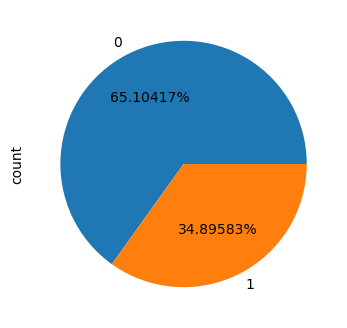

In [3]:
#라벨 확인
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (4,4)
df.Outcome.value_counts().plot(kind='pie', autopct='%0.05f%%')

In [4]:
# 특성, 라벨 분류 및 to_array
x=df.drop("Outcome",axis=1).values
y=df["Outcome"].values
print(x.shape,y.shape)

# 특성 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

(768, 8) (768,)


In [5]:
# train - test 분류
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(576, 8)
(192, 8)
(576,)
(192,)


In [6]:
# array -> tensor , train-test set 합치기
import torch

x_train=torch.tensor(x_train, dtype=torch.float32)
x_test=torch.tensor(x_test, dtype=torch.float32)
y_train=torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test=torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


from torch.utils.data import Dataset, DataLoader, TensorDataset

dataset_train = TensorDataset(x_train,y_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = TensorDataset(x_test,y_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([576, 8]),
 torch.Size([576, 1]),
 torch.Size([192, 8]),
 torch.Size([192, 1]))

In [7]:
#모델 정의
import torch.nn as nn
import torch.optim as optim


class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DiabetesDense()

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# loss, accuracy 기록
train_losses = []
test_accuracies = []

# 반복학습
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader_train:
        # 기울기 초기화
        optimizer.zero_grad()

        # loss 확인
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파, 가중치 업데트
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # 평균 로스 기록
    train_losses.append(running_loss / len(dataloader_train))

    # 평가상태 변
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader_test:
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) >= 0.5).float()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/25, Loss: 0.6540, Accuracy: 63.54%
Epoch 2/25, Loss: 0.6072, Accuracy: 70.31%
Epoch 3/25, Loss: 0.5577, Accuracy: 71.88%
Epoch 4/25, Loss: 0.5132, Accuracy: 75.52%
Epoch 5/25, Loss: 0.4888, Accuracy: 74.48%
Epoch 6/25, Loss: 0.4759, Accuracy: 76.56%
Epoch 7/25, Loss: 0.4710, Accuracy: 76.56%
Epoch 8/25, Loss: 0.4672, Accuracy: 76.56%
Epoch 9/25, Loss: 0.4629, Accuracy: 76.56%
Epoch 10/25, Loss: 0.4595, Accuracy: 78.12%
Epoch 11/25, Loss: 0.4582, Accuracy: 76.56%
Epoch 12/25, Loss: 0.4539, Accuracy: 77.60%
Epoch 13/25, Loss: 0.4513, Accuracy: 77.08%
Epoch 14/25, Loss: 0.4494, Accuracy: 77.60%
Epoch 15/25, Loss: 0.4467, Accuracy: 78.12%
Epoch 16/25, Loss: 0.4466, Accuracy: 78.12%
Epoch 17/25, Loss: 0.4415, Accuracy: 78.65%
Epoch 18/25, Loss: 0.4389, Accuracy: 79.17%
Epoch 19/25, Loss: 0.4368, Accuracy: 78.65%
Epoch 20/25, Loss: 0.4341, Accuracy: 78.65%
Epoch 21/25, Loss: 0.4310, Accuracy: 77.60%
Epoch 22/25, Loss: 0.4301, Accuracy: 77.08%
Epoch 23/25, Loss: 0.4279, Accuracy: 77.0

In [10]:
# 모델 평가
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


# 실제 라벨, 예측값 기록
all_labels = []
all_predictions = []

model.eval()

with torch.no_grad():
    for inputs, labels in dataloader_test:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) # 가장 확률 높은 열번호 
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# list->numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

#matrix, f1, precision, recall 확인
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# 각 specificity 확인
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]  # False Positive
    specificity.append(tn / (tn + fp))  # Specificity = TN / (TN + FP)

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[122   0]
 [ 70   0]]
F1 Score: 0.49
Precision: 0.40
Recall: 0.64
Specificity: 0.50


C:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


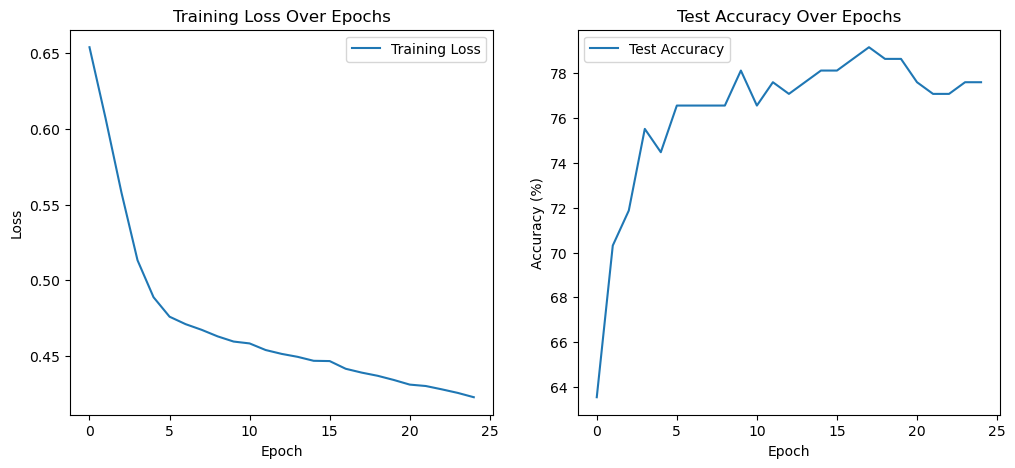

In [11]:
# loss와 accuracy 변화 확인


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()